In [157]:
import dicom
import pylab
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math
import pandas as pd

import scipy.ndimage
import skimage
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D

In [158]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces, x, y = measure.marching_cubes(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.7)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

- On a en sortie de Unet des masques en .npz
- On applique ces masques à l'image qu'on mettait en entrée de l'Unet -> on récupère le ou les nodule
- On prend un patch autour des nodules, taille à determiner 16x16x16?
- On met ce patch dans un CNN en 3D qui sort 0 ou 1

## Import de nodule_mask.npzet lung_img.npz

In [159]:
INPUT_FOLDER = '/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/slices'
patients_short = os.listdir(INPUT_FOLDER)

images = os.listdir(INPUT_FOLDER)
images_path = [os.path.join(INPUT_FOLDER,patient) for patient in patients_short]

In [160]:
##On crée 2 listes dans lesquels on écrit respectivement les paths des lung_img et les paths des nodule_mask 
images_path_lung_img = []
images_path_nodule_mask = []
for i in range(0,len(images_path)):
    if(images_path[i][-19:-8]=='nodule_mask'):
        images_path_nodule_mask.append(images_path[i])
    elif(images_path[i][-16:-8]=='lung_img'):
        images_path_lung_img.append(images_path[i])
    else:
        print(images_path[i])
        
##On sort ces listes pour avoir les slices d'un meme patient côte à côte
images_path_lung_img.sort()
images_path_nodule_mask.sort()

/Users/anthonypamart/Documents/SIR/Projets/CEI/Taff 15 mars/slices/.DS_Store


In [161]:
## Liste des id des patients
id_patients = []
for i in range(0,len(images_path_lung_img)):
    id_patients.append(images_path_lung_img[i][67:131])
id_patients = list(set(id_patients)) ##On tej les doublons

In [162]:
plt.imshow(np.load(images_path_nodule_mask[110]), cmap = plt.cm.bone)
#plt.show()

In [163]:
plt.imshow(np.load(images_path_lung_img[110]), cmap = plt.cm.bone)
#plt.show()

In [164]:
##PAS A METTRE DANS LE SCRIPT

##On charge nos .npz dans un numpy array

#nodule_mask = np.load(images_path_nodule_mask[110])
#lung_img = np.load(images_path_lung_img[110])

nodule_mask = np.load(images_path_nodule_mask[104])
lung_img = np.load(images_path_lung_img[104])

## Application d'un nodule_mask à une lung_img.npz

In [165]:
##Applique le nodule_mask au lung_img et renvoie donc le nodule_segmented
def get_nodule_segmented(nodule_mask,lung_img):
    nodule_segmented = lung_img.copy()
    for i in range(0,len(nodule_segmented)):
        for j in range(0,len(nodule_segmented)):
            if(nodule_mask[i][j]==0.0):
                nodule_segmented[i][j]=0.0
    return nodule_segmented

In [166]:
##PAS A METTRE DANS LE SCRIPT
nodule_segmented = get_nodule_segmented(nodule_mask,lung_img)

In [167]:
plt.imshow(nodule_segmented, cmap = plt.cm.bone)
#plt.show()

In [168]:
##Prend le nodule mask et renvoie les coordonnées des centres des nodules présents et le nb de nodules présents
def get_centers_nodules(nodule_mask):
    label_scan = label(nodule_mask)
    areas = [r.area for r in regionprops(label_scan)]
    #areas.sort()
    center_full = [r.centroid  for r in regionprops(label_scan)]
    nb_nodules = len(center_full)
    return center_full, nb_nodules

In [224]:
##PAS A METTRE DANS LE SCRIPT

##Calcule le nombre max de nodules dans toutes les slices
a = []
for i in range(0,len(images_path_nodule_mask)):
    nodule_mask = np.load(images_path_nodule_mask[i])
    center_full, nb_nodules = get_centers_nodules(nodule_mask)
    a.append(len(center_full))
print(max(a))

2


In [226]:
##PAS A METTRE DANS LE SCRIPT
center_full, nb_nodules = get_centers_nodules(nodule_mask)

In [170]:
##PAS A METTRE DANS LE SCRIPT

##On prend un patch 2D de taille 16x16 autour de chaque nodule détecté
first_nodule = nodule_segmented[int(center_full[0][0])-8:int(center_full[0][0])+8,int(center_full[0][1])-8:int(center_full[0][1])+8]
second_nodule = nodule_segmented[int(center_full[1][0])-8:int(center_full[1][0])+8,int(center_full[1][1])-8:int(center_full[1][1])+8]

In [171]:
plt.imshow(second_nodule, cmap = plt.cm.bone)
#plt.show()

## Passage en 3D

- On prendra tout au long l'exemple du patient dont les slices se retrouvent avec "images_path_nodule_mask[99:116]"
- (on a sorté images_path_nodule_mask au début du notebook)    
- (ID de ce patient : 1.3.6.1.4.1.14519.5.2.1.6279.6001.272042302501586336192628818865_214)

In [172]:
##Les slices 99 à 116 qui nous interesse pour plotter en 3D nos 2 nodules d'exemples
len(images_path_nodule_mask[99:116])

17

In [173]:
##Pour récupérer le path des lung_img pour le patient dont on précise l'ID
def get_patients_path_lung_img(images_path_lung_img, ID='1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097'):
    patients_path_lung_img = []
    for i in range(0,len(images_path_lung_img)):
        #if(images_path_lung_img[i][67:131]==id_patients[0]):
        if(images_path_lung_img[i][67:131]==ID):
            patients_path_lung_img.append(images_path_lung_img[i])
    patients_path_lung_img.sort()
    return patients_path_lung_img

In [174]:
##Pour récupérer le path des nodule_mask pour le patient dont on précise l'ID
def get_patients_path_nodule_mask(images_path_nodule_mask, ID='1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097'):
    patients_path_nodule_mask = []
    for i in range(0,len(images_path_nodule_mask)):
        if(images_path_nodule_mask[i][67:131]==ID):
            patients_path_nodule_mask.append(images_path_nodule_mask[i])
    patients_path_nodule_mask.sort()
    return patients_path_nodule_mask

In [175]:
##PAS A METTRE DANS LE SCRIPT

#patients_path_lung_img = get_patients_path_lung_img(images_path_lung_img, id_patients[0])
#patients_path_nodule_mask = get_patients_path_nodule_mask(images_path_nodule_mask, id_patients[0])

patients_path_lung_img = get_patients_path_lung_img(images_path_lung_img)
patients_path_nodule_mask = get_patients_path_nodule_mask(images_path_nodule_mask)

In [201]:
##Pour le patient pris en exemple, on construit nodule_mask_3D, lung_img_3D et nodule_segmented_3D

##On met en entrée le path des nodule_mask du patient et on a en sortie un np array 3D avec le nodule mask (2D)
##de toutes les slices (ce qui ajoute une 3e dimension)
def get_nodule_mask_3D(patients_path_nodule_mask, dim_x=512, dim_y=512):
    nodule_mask_3D = np.zeros((dim_x, dim_y, len(patients_path_nodule_mask)))
    for i in range(0,len(patients_path_nodule_mask)):
        nodule_mask_3D[:,:,i] = np.load(patients_path_nodule_mask[i]) ##Pas ouf de loader à chaque fois ??
    return nodule_mask_3D

##On met en entrée le path des lung_img du patient et on a en sortie un np array 3D avec la lung_img (2D)
##de toutes les slices (ce qui ajoute une 3e dimension)
def get_lung_img_3D(patients_path_lung_img, dim_x=512, dim_y=512):
    lung_img_3D = np.zeros((dim_x, dim_y, len(patients_path_lung_img)))
    for i in range(0,len(patients_path_lung_img)):
        lung_img_3D[:,:,i] = np.load(patients_path_lung_img[i]) ##Pas ouf de loader à chaque fois ??
    return lung_img_3D

##On met en entrée le path des lung_img du patient et le path des nodule_mask et on a en sortie un np array 3D
##avec le nodule segmenté (2D) de toutes les slices (ce qui rajoute une 3e dimension)
def get_nodule_segmented_3D(patients_path_nodule_mask, patients_path_lung_img, dim_z = len(patients_path_lung_img), dim_x =512, dim_y=512):
    nodule_segmented_3D = np.zeros((dim_x, dim_y, dim_z))
    
    a= min(len(patients_path_lung_img), dim_z)
    for i in range(0,a):
        nodule_segmented_3D[:,:,i] = get_nodule_segmented(get_nodule_mask_3D(patients_path_nodule_mask)[:,:,i],get_lung_img_3D(patients_path_lung_img)[:,:,i])
    return nodule_segmented_3D

In [210]:
##PAS A METTRE DANS LE SCRIPT
nodule_segmented_3D = get_nodule_segmented_3D(patients_path_nodule_mask, patients_path_lung_img)

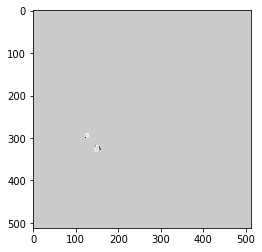

In [211]:
plt.imshow(nodule_segmented_3D[:,:,11], cmap=plt.cm.gray)
#plt.show()

In [179]:
##On stock les center_full et les nb_nodules dans des listes center_full_3D et nb_nodules_3D

def get_center_nodules_3D(patients_path_nodule_mask):
    center_full_3D = []
    nb_nodules_3D = []

    for i in range(0, len(patients_path_nodule_mask)):
        nodule_mask_3D = get_nodule_mask_3D(patients_path_nodule_mask)
        center_full, nb_nodules = get_centers_nodules(nodule_mask_3D[:,:,i])
        center_full_3D.append(center_full)
        nb_nodules_3D.append(nb_nodules)
        
    return center_full_3D, nb_nodules_3D

In [180]:
##PAS A METTRE DANS LE SCRIPT
center_full_3D, nb_nodules_3D = get_center_nodules_3D(patients_path_nodule_mask)

In [181]:
##PAS A METTRE DANS LE SCRIPT

##Cette façon de sélectionner les différents nodules ne fonctionnent pas dans un cas général

first_nodule_3D = np.zeros((first_nodule.shape[0], first_nodule.shape[1], len(nb_nodules_3D)))
for i in range(0,len(nb_nodules_3D)):
    first_nodule_3D[:,:,i] = nodule_segmented_3D[int(center_full_3D[i][-1][0])-8:int(center_full_3D[i][-1][0])+8,int(center_full_3D[i][-1][1])-8:int(center_full_3D[i][-1][1])+8,i]
    
second_nodule_3D = np.zeros((second_nodule.shape[0], second_nodule.shape[1], 17))
for i in range(5,16):
    second_nodule_3D[:,:,i] = nodule_segmented_3D[int(center_full_3D[i][-2][0])-8:int(center_full_3D[i][-2][0])+8,int(center_full_3D[i][-2][1])-8:int(center_full_3D[i][-2][1])+8,i]

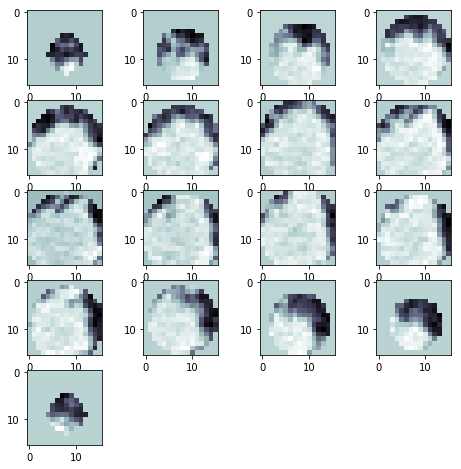

In [183]:
##First Nodule

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(0, 17):
    img = first_nodule_3D[:,:,i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap = plt.cm.bone)
plt.show()

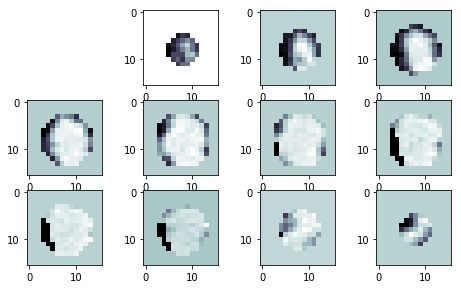

In [184]:
##Second Nodule

fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(5, 16):
    img = second_nodule_3D[:,:,i]
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(img, cmap = plt.cm.bone)
plt.show()

In [34]:
#plot_3d(second_nodule_3D, 0) ##Seuil à optimiser

- Admettons qu'on décide de donner au réseau de neurone 1 seul nodule et qu'on fixe sa taille à 16x16x16 (on fera du padding ou on tejera des coupes en trop si necessaire)
- Avec la fonction ci dessous, si il y a plus de slices que 16, on ne prends pas en compte celles en trop et si il y en a moins que 16, on pad
- Si on décommente les 2 lignes en commentaires, on récupère le vrai nodule en 3D, sans troncature ou padding

In [237]:
##Verifier que la fonction fonctionne bien dans le cas general (surtout ligne de construction de first_nodule_3D)
##Voir si on prend bien le nodule le plus pertinent avec cette fonction
##Voir si on prend qu'un seul nodule de taille 16x16x16 (c'est ce que fait cette fonction)
def npz_to_cnn(images_path_lung_img, images_path_nodule_mask, ID, dimx_nodule = 16, dimy_nodule = 16, dimz_nodule = 16):
    patients_path_lung_img = get_patients_path_lung_img(images_path_lung_img, ID)
    patients_path_nodule_mask = get_patients_path_nodule_mask(images_path_nodule_mask, ID)
    nodule_segmented_3D = get_nodule_segmented_3D(patients_path_nodule_mask, patients_path_lung_img, dimz_nodule)
    center_full_3D, nb_nodules_3D = get_center_nodules_3D(patients_path_nodule_mask)
    a = min(len(center_full_3D), dimz_nodule)
        
    ##Si les éléments de center_full_3d sont trop éloignés, cela veut surement dire qu'on a confondu 2 nodules
    ##lorsqu'on a pris les 2 plus grandes areas dans le preprocessing (esperons que ca n'arrive pas)
    print(center_full_3D) 
    
    #first_nodule_3D = np.zeros((dimx_nodule, dimy_nodule, len(nb_nodules_3D)))
    first_nodule_3D = np.zeros((dimx_nodule, dimy_nodule, dimz_nodule)) 
    
    #for i in range(0,len(nb_nodules_3D)):
    for i in range(0,a):
        first_nodule_3D[:,:,i] = nodule_segmented_3D[int(center_full_3D[i][-1][0])-dimx_nodule/2:int(center_full_3D[i][-1][0])+dimx_nodule/2,int(center_full_3D[i][-1][1])-dimy_nodule/2:int(center_full_3D[i][-1][1])+dimy_nodule/2,i]
    return first_nodule_3D

In [247]:
%%time
first_nodule_3D = npz_to_cnn(images_path_lung_img, images_path_nodule_mask, '1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097')
print(first_nodule_3D.shape)

[[(324.84313725490193, 150.0)], [(324.9191919191919, 150.0)], [(324.9136690647482, 150.0)], [(325.0, 150.0)], [(324.8128078817734, 150.0)], [(294.0, 126.0), (324.94618834080717, 150.0)], [(294.0, 126.0), (325.0, 150.0)], [(294.0, 126.0), (324.9020408163265, 150.0)], [(294.0, 126.0), (324.964, 150.0)], [(294.0, 126.0), (324.9020408163265, 150.0)], [(294.0, 126.0), (325.0, 150.0)], [(294.0, 126.0), (324.94618834080717, 150.0)], [(294.0, 126.0), (324.8128078817734, 150.0)], [(294.0, 126.0), (325.0, 150.0)], [(294.0, 126.0), (324.9136690647482, 150.0)], [(294.0, 126.0), (324.9191919191919, 150.0)], [(324.84313725490193, 150.0)]]
(16, 16, 16)
CPU times: user 5.42 s, sys: 648 ms, total: 6.07 s
Wall time: 6.19 s


In [246]:
%%time

nodule_3D = npz_to_cnn(images_path_lung_img, images_path_nodule_mask, id_patients[6])
#plot_3d(nodule_3D)

[[(243.5, 147.5)], [(243.5, 147.5)], [(243.5, 147.5)], [(243.5, 147.5)], [(243.5, 147.5), (255.0, 156.0)], [(243.5, 147.5), (255.0, 156.0)], [(243.5, 147.5), (255.0, 156.0)], [(243.5, 147.5), (255.0, 156.0)], [(255.0, 156.0)], [(255.0, 156.0)], [(255.0, 156.0)], [(255.0, 156.0)], [(255.0, 156.0)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)], [(323.5, 170.5)]]
CPU times: user 7.42 s, sys: 1.01 s, total: 8.44 s
Wall time: 8.61 s


- Problème 1) se met en évidence en printant les center_full_3D de id_patients[8] et de '1.3.6.1.4.1.14519.5.2.1.6279.6001.137763212752154081977261297097' par exemple :
- On remarque que quand on a 2 nodules, ils sont classés dans center_full par ordre croissant (je pense) selon la premiere coordonnées
- Ca fout le bordel et mon -1 dans center_full_3D[i][-1][0] n'est pas bon
- Vu qu'il y a peu de gens qui ont 2 nodules, à voir si on se fait chier à régler le pb ou si on ballec
- Sinon on sélectionne le nodule qui apparait dans le plus de slice ?
- Ou on peut sélectionner le nodule qui a l'area la plus importante toutes slices confondues ?


- Problème 2) le fait que dans le preprocessing, on selectionne uniquement les deux plus grosses areas d'une slice fausse la détection 3D des nodules (sur une slice, les 2 plus gros nodules ne sont pas forcément ceux qui ont la plus grosse area sur la slice en question, ça dépend si la slice les coupe en plein milieu ou au niveau d'une extremité)

## Implémentation du CNN : (Pas finie)
- https://www.kaggle.com/sentdex/first-pass-through-data-w-3d-convnet

In [127]:
from keras import layers
from keras import models
from keras import optimizers

In [128]:
image_channels = 1

model = models.Sequential()

model.add(layers.Conv3D(32, (3,3,3), activation = 'relu', input_shape = (16,16,16,image_channels)))
model.add(layers.MaxPooling3D((2,2,2)))

model.add(layers.Conv3D(64, (3,3,3), activation = 'relu'))
model.add(layers.MaxPooling3D((2,2,2)))

model.add(layers.Dense(4096, activation='relu')) ##4096 pris un peu au pif (16x16x16)
model.add(layers.Dropout(0.8))

model.add(layers.Dense(1, kernel_initializer='normal', activation='sigmoid')) ##Couche de sortie
          
model.compile(loss='binary_crossentropy',
                      optimizer=optimizers.Adam(lr=1e-3)) ##Quel loss choisir ?

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_26 (Conv3D)           (None, 14, 14, 14, 32)    896       
_________________________________________________________________
max_pooling3d_22 (MaxPooling (None, 7, 7, 7, 32)       0         
_________________________________________________________________
conv3d_27 (Conv3D)           (None, 5, 5, 5, 64)       55360     
_________________________________________________________________
max_pooling3d_23 (MaxPooling (None, 2, 2, 2, 64)       0         
_________________________________________________________________
dense_13 (Dense)             (None, 2, 2, 2, 4096)     266240    
_________________________________________________________________
dropout_9 (Dropout)          (None, 2, 2, 2, 4096)     0         
_________________________________________________________________
dense_14 (Dense)             (None, 2, 2, 2, 1)        4097      
Total para

In [129]:
train_images = np.reshape(first_nodule_3D, (1,16,16,16,1))
train_labels = np.zeros((1,2,2,2,1)) ##Foireux, à modifier, mais le réseau voulait ce shape
model.fit(train_images, train_labels, epochs=5, batch_size=1)

Epoch 1/5
1/1 [==============================] - 1s 902ms/step - loss: 12.6738
Epoch 2/5
1/1 [==============================] - 0s 63ms/step - loss: 3.4292e-06
Epoch 3/5
1/1 [==============================] - 0s 70ms/step - loss: 1.0000e-07
Epoch 4/5
1/1 [==============================] - 0s 72ms/step - loss: 1.0000e-07
Epoch 5/5
1/1 [==============================] - 0s 67ms/step - loss: 1.0000e-07


In [ ]:
##code Kaggle
""""
    weights = {'W_conv1':tf.Variable(tf.random_normal([3,3,3,1,32])),
               #       5 x 5 x 5 patches, 32 channels, 64 features to compute.
               'W_conv2':tf.Variable(tf.random_normal([3,3,3,32,64])),
               #                                  64 features
               'W_fc':tf.Variable(tf.random_normal([54080,1024])),
               'out':tf.Variable(tf.random_normal([1024, n_classes]))}

    biases = {'b_conv1':tf.Variable(tf.random_normal([32])),
               'b_conv2':tf.Variable(tf.random_normal([64])),
               'b_fc':tf.Variable(tf.random_normal([1024])),
               'out':tf.Variable(tf.random_normal([n_classes]))}

    #                            image X      image Y        image Z
    x = tf.reshape(x, shape=[-1, IMG_SIZE_PX, IMG_SIZE_PX, SLICE_COUNT, 1])

    conv1 = tf.nn.relu(conv3d(x, weights['W_conv1']) + biases['b_conv1'])
    conv1 = maxpool3d(conv1)


    conv2 = tf.nn.relu(conv3d(conv1, weights['W_conv2']) + biases['b_conv2'])
    conv2 = maxpool3d(conv2)

    fc = tf.reshape(conv2,[-1, 54080])
    fc = tf.nn.relu(tf.matmul(fc, weights['W_fc'])+biases['b_fc'])
    fc = tf.nn.dropout(fc, keep_rate)

    output = tf.matmul(fc, weights['out'])+biases['out']
"""""